# Sentimental Analysis

We have a dataset of customer feedbacks with various sentiments. We have to build a machine learning classifier which trains on this dataset to analyse the respective sentiments and predict the sentiments of other unlabelled texts.

## Data Preprocessing

First we import the important dependencies required by the task at hand

In [1]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

We will be explaining each modules as to the purpose they serve.

1. os is used for detecting the data file.
2. nltk(Natural Language Toolkit) is used for text preprocessing, i.e. removal of stopwords and punctuations and stemming the texts of words of the same semantics. 
3. numpy is used for linear algebra and vector arithmetic.
4. pandas are used for analysing sequences and for reading and storing data.
5. matplotlib is a data visualization module.
6. sklearn is a simple machine learning framework with easy to implement functions. We can also use its many predefined functions to preprocess our data. We mainly use them for creating Bag of Words, accuracy measurement of our model and for the Naive Bayes and Support Vector Machine classifier.

Next we download a corpus of stopwords, punctuations, etc. belonging to nltk

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Next we read our data using pandas.

In [3]:
dataframe = pd.read_csv(os.path.join('data',os.listdir('data')[0]),sep = '\t', names = ['id', 'feedback', 'sentiment'])

We use the read_csv() function of pandas which is normally used to read from .csv files. But we can easily use it to read simple text files. Our data is actually in the following format "'customer id'\t'feedback'\t'sentiment'" hence we named the rows in this way. 
    
We can easily show that the data is in this format by simple file io of python

In [4]:
with open(os.path.join('data',os.listdir('data')[0]),'rb') as data_file:
    l = data_file.readlines()

l[0:5]

[b'en-development-0001\tWakes your brain up!\tcomment\n',
 b'en-development-0002\tThe location is perfect with Marais being a great area to stay in with restaurants, shops, cafes, bars and the metro all close by.\tcomment\n',
 b'en-development-0003\tDespite the noise and bustle outside, the rooms are very quiet, and we overlooked Las Ramblas.\tcomment\n',
 b'en-development-0004\tWe travel often and usually stay at very nice hotels.\tcomment\n',
 b"en-development-0005\tThis was so bad experience that i wouln't stay again in this hotel.\tcomplaint\n"]

We can visualize the dataframe we created from our dataset. Pandas automatically analyzes and structures our data in a tabular form.

In [5]:
dataframe.head()

,id,feedback,sentiment
0,en-development-0001,Wakes your brain up!,comment
1,en-development-0002,The location is perfect with Marais being a gr...,comment
2,en-development-0003,"Despite the noise and bustle outside, the room...",comment
3,en-development-0004,We travel often and usually stay at very nice ...,comment
4,en-development-0005,This was so bad experience that i wouln't stay...,complaint


We are going to define a sentiment to value index to mathematically approach the problem

In [6]:
sentiment_word_to_value = {'comment' : 1,
                           'complaint' : 2,
                           'meaningless' : 3,
                           'request' : 4,
                           'bug' : 5,
                           'comment, complaint' : 6,
                           'complaint, bug' : 7,
                           'request, complaint' : 8,
                           'complaint, request' : 8,
                           'bug, complaint' : 7,
                           'undefined' : 0}

We now rid the data of stopwords and punctuations and then stem the data. But before all of them we convert the data to lowercase as that may interfere with the removal of stopwords

In [7]:
list_of_feedbacks = list(dataframe.feedback.values)
#Tokenization of the data
tokenized_data = [nltk.tokenize.word_tokenize(sents) for sents in list_of_feedbacks]
#convertion to lowercase
lowercase_tokenied_data = []
for e in tokenized_data:
    temp = [words.lower() for words in e]
    lowercase_tokenied_data.append(temp)
#Removal of punctuations
corpus_without_punctuations = []
for e in lowercase_tokenied_data:
    temp = [words for words in e if words.isalpha()]
    corpus_without_punctuations.append(temp)
#Removal of stopwords
corpus_without_puncts_stopwords = []
stopwords_english = set(nltk.corpus.stopwords.words('english'))
for e in corpus_without_punctuations:
    temp = [words for words in e if not words in stopwords_english]
    corpus_without_puncts_stopwords.append(temp)
#Stemming the tokens
clean_corpus = []
stemmer = nltk.stem.SnowballStemmer('english')
for e in corpus_without_puncts_stopwords:
    temp = [stemmer.stem(words) for words in e]
    clean_corpus.append(temp)
corpus_of_data = [" ".join(sents) for sents in clean_corpus]

We add the clean_corpus back to the feedback column. The data is now ready for being converte to the Bag of Words(BoW) model.

In [8]:
dataframe.feedback = corpus_of_data
dataframe.head()

,id,feedback,sentiment
0,en-development-0001,wake brain,comment
1,en-development-0002,locat perfect marai great area stay restaur sh...,comment
2,en-development-0003,despit nois bustl outsid room quiet overlook l...,comment
3,en-development-0004,travel often usual stay nice hotel,comment
4,en-development-0005,bad experi woul stay hotel,complaint


We now convert the feedback data into the BoW model. Also we map the sentiment with the respective value.

In [9]:
bow = TfidfVectorizer()
corpus_of_data = list(dataframe.feedback.values)
features = bow.fit_transform(corpus_of_data)
#We make a copy of the dataframe to maintained the integrity of the initial one
dataframe_copy = dataframe.copy()
#We map the sentiment to the values we created for each of them earlier
for key,value in sentiment_word_to_value.items():
    dataframe_copy.sentiment[dataframe.sentiment == key] = value
labels = list(dataframe_copy.sentiment.values)

## Visualizing the data

We use matplotlib to visualize the data in order to construct the training and testing set.

Text(0,0.5,'Sentiments')

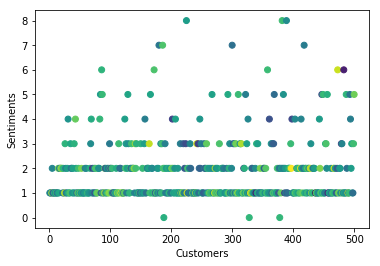

In [10]:
plt.scatter(range(1,501), labels, c = np.random.randn(500))
plt.xlabel('Customers')
plt.ylabel('Sentiments')

## Training

We have our features and labels. We now divide them into training and testing phases.

We do this by keeping 80% of our data for training the model. The remaining 20% of the data is used to test our model's accuracy

In [11]:
training_index = int(0.8 * 500)
x_train, y_train = features[-training_index:], labels[-training_index:]
x_test, y_test = features[:-training_index], labels[:-training_index]

We now create the classifier. We use the Multinomial Naive Bayes classifier because we have more than 1 class of sentiments.

In [12]:
nb_clf = MultinomialNB(alpha = 1)
svm_clf = LinearSVC()

We now fit our features with the labels using this classifier.

In [13]:
nb_clf.fit(x_train, y_train)
svm_clf.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Prediction and Accuracy

Now we can calculate the accuracy of our model from the validation set

In [14]:
pred = nb_clf.predict(x_test)
svm_pred = svm_clf.predict(x_test)

In [15]:
print('Naive Bayes accuracy:',accuracy_score(y_test, pred))
print('Support Vector Machine accuracy:',accuracy_score(y_test, svm_pred))

Naive Bayes accuracy: 0.59
Support Vector Machine accuracy: 0.62


## Discussions

We have analysed and visualized the dataset to see that the data in the begining are mostly containing a single class of sentiment with slight variations. So we took the data from the end as our training set to introduce variations to better train the model. 

Our Multiclass Naive Bayes classifier achieved an accuracy of 59%. The accuracy on the training data was 69.75%. If we trained on the whole dataset the validation set gives an accuracy of 78%. 

The Linear Support Vector Machine achieved an accuracy score of 62%. The accuracy on the training data was 98.75%. While training on the whole dataset produced a validation set accuracy of 99%.

The accuracy can be improved with more data and increased variation among them. 

The Linear SVM proves to be a better classifier due to it's one vs all strategy for sentiment analysis. 

We used the Tf-Idf approach as they give an enhanced semantic to the corpus. The accuracy can be improved by increasing variation in the dataset and increasing the number of data available. 

## Team Members

1. Archisman Ghosh (Class roll: 12)
2. Arkadyuti Paul (Class roll: 14)
3. Debajyoti Chakraborty (Class roll: 26)
4. Debanjan Mondal (Class roll: 28)
5. Jeet Dutta (Class roll: 35)